# Model evaluation

* in this notebook we will compare models' performance during training by looking at the train/val curves

* we will also test model performance with the test data and will show the results in the form of confusion maps


In [155]:
import os
os.chdir('/Users/simpleai/Desktop/az_task/scripts/')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision import transforms
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import f1_score


from utils import img_viewer
from dataset import get_loader
from model import MyVGG16

In [183]:
# making a dictionary of train/val curves
root_dir = '/Users/simpleai/Desktop/az_task/results/task2'
train_val_df = {}

for model in ['vgg16', 'resnet50']:
    for classification in ['binary', 'multiclass']:
        train_val_df[f"{classification}_{model}"] = pd.read_csv(
            f"{root_dir}/{model}_{classification}_classifier_info.csv",
            index_col=0
        )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


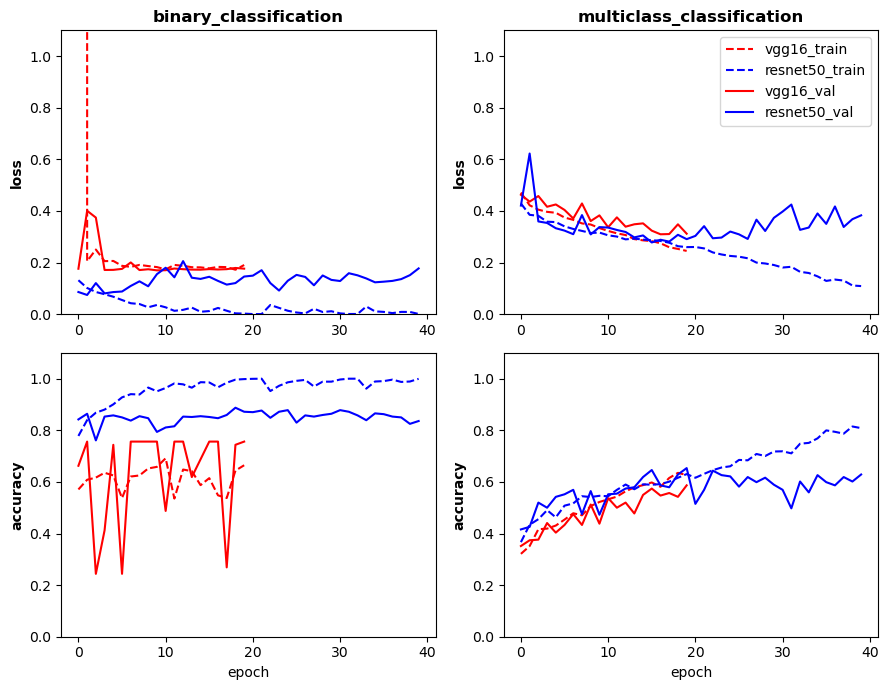

In [185]:
# making train/val curve plots
fig, ax = plt.subplots(2, 2, figsize=(9,7))
for s,session in enumerate(['train', 'val']):
    for m,model in enumerate(['vgg16', 'resnet50']):
        for c,classification in enumerate(['binary', 'multiclass']):
            for m,metric in enumerate(['loss', 'accuracy']): 
                color = 'r' if model=='vgg16' else 'b'
                style = '-' if session=='val' else '--'
                ax[m][c].plot(train_val_df[f"{classification}_{model}"][f"{session}_epoch"], 
                              train_val_df[f"{classification}_{model}"][f"{session}_{metric}"], 
                              label=f"{model}_{session}", c=color, linestyle=style)
                ax[m][c].set_ylabel(metric, fontweight='bold')
                
                ax[1][c].set_xlabel('epoch')
                ax[0][c].set_title(f"{classification}_classification", fontweight='bold')
                ax[m][c].set_ylim([0,1.1])
            ax[0][1].legend()
handles, labels = ax[0][0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncols=4, bbox_to_anchor=(0.5, -0.03, 0, 0))
plt.tight_layout()
plt.savefig('/Users/simpleai/Desktop/az_task/results/task3/train_val_curves.png', dpi=600)
plt.show()

# Performing sensitivity-specificity analysis 

In [186]:
BATCH_SIZE=4
device = "mps" if torch.backends.mps.is_available() else "cpu" # I'm using an M1 chip which can perform vectorized calculations over Mac GPU using ARM technology
NUM_CLASSES_binary = 2
NUM_CLASSES_multi = 7

# transform will include on-the-fly augmentations later
transform = transforms.Compose([
   transforms.ToTensor(), 
   transforms.Resize((256,256)), # resizing to 256 by 256 due to having limited amount of ram available on my Mac
   transforms.Normalize(
       mean=[0.4914, 0.4822, 0.4465], 
       std=[0.2023, 0.1994, 0.2010]
       )
   ])

# load the test data_df for binary and multiclass models
bi_label_df_path = '/Users/simpleai/Desktop/az_task/results/task1/binary_classification_metadata.csv'
bi_label_df = pd.read_csv(bi_label_df_path, index_col=0)
bi_test_df = bi_label_df.loc[bi_label_df['type']=='Test', :]
bi_test_df = bi_test_df.reset_index(drop=True)

mu_label_df_path = '/Users/simpleai/Desktop/az_task/results/task1/multiclass_classification_metadata.csv'
mu_label_df = pd.read_csv(mu_label_df_path, index_col=0)
mu_test_df = mu_label_df.loc[mu_label_df['type']=='Test', :]
mu_test_df = mu_test_df.reset_index(drop=True)

# make a dataloader on the test data_dfs
binaryclass_loader = get_loader(
    data_df = bi_test_df, 
    label_cols = ['Healthy', 'Disease_Risk'],
    batch_size = BATCH_SIZE, 
    transform = transform, 
    shuffle = False
)

multiclass_loader = get_loader(
    data_df = mu_test_df, 
    label_cols = ['Healthy', 'DR', 'ARMD', 'MH', 'DN', 'TSLN', 'ODC'],
    batch_size = BATCH_SIZE, 
    transform = transform, 
    shuffle = False)

# load the models
# vgg16 binary classifier
vggmodel_binary_path = '/Users/simpleai/Desktop/az_task/results/task2/vgg16_binary_classifier.pth'
vggmodel_binary = MyVGG16(num_classes=NUM_CLASSES_binary, input_height=256, input_width=256).to(device)
for m in vggmodel_binary.modules():
    for child in m.children():
        if type(child)==nn.BatchNorm2d:
            child.track_running_stats = False
            child.running_mean = None
            child.running_var = None
vggmodel_binary.load_state_dict(torch.load(vggmodel_binary_path))

# vgg16 multiclass classifier
vggmodel_multi_path = '/Users/simpleai/Desktop/az_task/results/task2/vgg16_multiclass_classifier.pth'
vggmodel_multi = MyVGG16(num_classes=NUM_CLASSES_multi, input_height=256, input_width=256).to(device)
for m in vggmodel_multi.modules():
    for child in m.children():
        if type(child)==nn.BatchNorm2d:
            child.track_running_stats = False
            child.running_mean = None
            child.running_var = None
vggmodel_multi.load_state_dict(torch.load(vggmodel_multi_path))

# rednet50 binary classifier
resnet50_binary_path = '/Users/simpleai/Desktop/az_task/results/task2/resnet50_binary_classifier.pth'
resnet50_binary = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50_binary.fc = nn.Linear(2048, NUM_CLASSES_binary)
resnet50_binary.load_state_dict(torch.load(resnet50_binary_path))
resnet50_binary = resnet50_binary.to(device)

# rednet50 multiclass classifier
resnet50_multi_path = '/Users/simpleai/Desktop/az_task/results/task2/resnet50_multiclass_classifier.pth'
resnet50_multi = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
resnet50_multi.fc = nn.Linear(2048, NUM_CLASSES_multi)
resnet50_multi.load_state_dict(torch.load(resnet50_multi_path))
resnet50_multi = resnet50_multi.to(device)



In [187]:
# loop through the dataloader and pass the data to the model
conf_mats = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((7,7)), np.zeros((7,7))]
models = [vggmodel_binary, resnet50_binary, vggmodel_multi, resnet50_multi]
loaders = [binaryclass_loader, binaryclass_loader, multiclass_loader, multiclass_loader]

for s, (model, loader, conf_mat) in enumerate(zip(models, loaders, conf_mats)):
    print(f"Performing sensitivity-specificity analysis for model {s}")
    model.eval()
    with torch.no_grad():
        for index, (image, labels) in enumerate(loader):
            image = image.type(torch.float32).to(device)
            output = model(image)
            for n,(r,p) in enumerate(zip(torch.argmax(labels, dim=1), torch.argmax(output, dim=1))):
                conf_mat[p,r] = conf_mat[p,r] + 1
    conf_mats[s] = conf_mat



Performing sensitivity-specificity analysis for model 0
Performing sensitivity-specificity analysis for model 1
Performing sensitivity-specificity analysis for model 2
Performing sensitivity-specificity analysis for model 3


In [188]:
# calculating f1 scores
def f1_calc(conf_mat):
    real_label = []
    pred_label = []
    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            real_label.append([j]*int(conf_mat[i,j]))
            pred_label.append([i]*int(conf_mat[i,j]))
            
    real_label = sum(real_label,[])
    pred_label = sum(pred_label,[])
    return f1_score(real_label, pred_label, average='weighted')



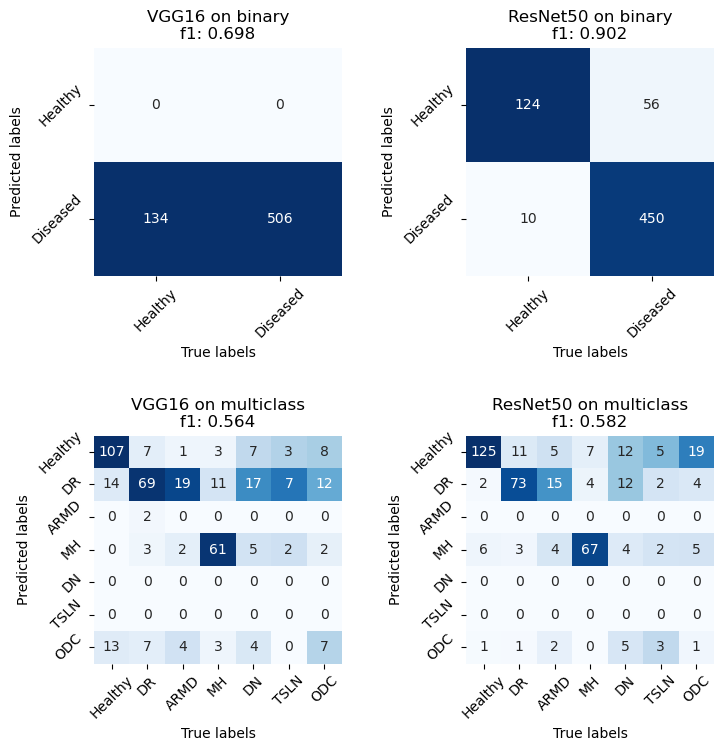

In [189]:
# plotting confusion matrices
fig, ax = plt.subplots(2,2,figsize=(8,8))
plt.subplots_adjust(hspace=0.7, wspace=0.5)
#plt.tight_layout()

sns.heatmap(conf_mats[0]/conf_mats[0].sum(axis=0), annot=conf_mats[0], fmt='g', cmap="Blues", cbar=False, ax=ax[0][0])
sns.heatmap(conf_mats[1]/conf_mats[1].sum(axis=0), annot=conf_mats[1], fmt='g', cmap="Blues", cbar=False, ax=ax[0][1])
sns.heatmap(conf_mats[2]/conf_mats[2].sum(axis=0), annot=conf_mats[2], fmt='g', cmap="Blues", cbar=False, ax=ax[1][0])
sns.heatmap(conf_mats[3]/conf_mats[3].sum(axis=0), annot=conf_mats[3], fmt='g', cmap="Blues", cbar=False, ax=ax[1][1])

ax[0][0].set_xlabel('True labels')
ax[0][1].set_xlabel('True labels')
ax[1][0].set_xlabel('True labels')
ax[1][1].set_xlabel('True labels')

ax[0][0].set_ylabel('Predicted labels')
ax[0][1].set_ylabel('Predicted labels')
ax[1][0].set_ylabel('Predicted labels')
ax[1][1].set_ylabel('Predicted labels')

ax[0][0].set_title(f'VGG16 on binary\nf1: {f1_calc(conf_mats[0]):.3f}')
ax[0][1].set_title(f'ResNet50 on binary\nf1: {f1_calc(conf_mats[1]):.3f}')
ax[1][0].set_title(f'VGG16 on multiclass\nf1: {f1_calc(conf_mats[2]):.3f}')
ax[1][1].set_title(f'ResNet50 on multiclass\nf1: {f1_calc(conf_mats[3]):.3f}')

ax[0][0].xaxis.set_ticklabels(['Healthy', 'Diseased'], rotation=45)
ax[0][1].xaxis.set_ticklabels(['Healthy', 'Diseased'], rotation=45)
ax[1][0].xaxis.set_ticklabels(['Healthy', 'DR', 'ARMD', 'MH', 'DN', 'TSLN', 'ODC'], rotation=45)
ax[1][1].xaxis.set_ticklabels(['Healthy', 'DR', 'ARMD', 'MH', 'DN', 'TSLN', 'ODC'], rotation=45)

ax[0][0].yaxis.set_ticklabels(['Healthy', 'Diseased'], rotation=45)
ax[0][1].yaxis.set_ticklabels(['Healthy', 'Diseased'], rotation=45)
ax[1][0].yaxis.set_ticklabels(['Healthy', 'DR', 'ARMD', 'MH', 'DN', 'TSLN', 'ODC'], rotation=45)
ax[1][1].yaxis.set_ticklabels(['Healthy', 'DR', 'ARMD', 'MH', 'DN', 'TSLN', 'ODC'], rotation=45)
plt.savefig('/Users/simpleai/Desktop/az_task/results/task3/conf_mat.png', dpi=600)
plt.show()
